<a href="https://colab.research.google.com/github/GabrielOlem/projetoPLN/blob/main/ATIS_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS

In [247]:
import tensorflow as tf
import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, RepeatVector, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


## LOAD DATASET AND GET TOKENS, SLOTS AND INTENTS, AND THEIR INDEXES

In [2]:
def load_ds(fname):
    #fname = os.path.join('/content/drive/MyDrive/CIn/2021.1/PLN_projeto',fname)
    with open(fname, 'rb') as stream:
        ds, dicts = pickle.load(stream)
    print('Done  loading: ', fname)
    print('      samples: {:4d}'.format(len(ds['query'])))
    print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
    print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
    print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds, dicts

In [3]:
train_ds, dicts = load_ds('atis.train.pkl')
test_ds, _ = load_ds('atis.test.pkl')

Done  loading:  atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Done  loading:  atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26


In [4]:
t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t, i2s, i2in = map(lambda d: {d[k]: k for k in d.keys()}, [t2i, s2i, in2i])
query, slots, intent = map(train_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

In [5]:
t2i_test, s2i_test, in2i_test = map(dicts.get, ['token_ids', 'slot_ids', 'intent_ids'])
i2t_test, i2s_test, i2in_test = map(lambda d: {d[k]: k for k in d.keys()}, [t2i_test, s2i_test, in2i_test])
query_test, slots_test, intent_test = map(test_ds.get,
                           ['query', 'slot_labels', 'intent_labels'])

## REMOVE WORDS FROM 'OTHER' SLOT CATEGORY

## GENERATE X AND Y PAIRING

In [6]:
X = query + query_test
y = slots + slots_test

x_text, y_all = [], []
for i, k in zip(X, y):
    tmp,tmpy = [], []
    for j, l in zip(i, k):
        if i2t[j] != "EOS" and i2t[j] != "BOS":
            tmp.append(i2t[j])
            tmpy.append(l)
    x_text.append(tmp)
    y_all.append(tmpy)
print(x_text[0])
print(y_all[0])


['i', 'want', 'to', 'fly', 'from', 'boston', 'at', '838', 'am', 'and', 'arrive', 'in', 'denver', 'at', '1110', 'in', 'the', 'morning']
[128, 128, 128, 128, 128, 48, 128, 35, 100, 128, 128, 128, 78, 128, 14, 128, 128, 12]


In [7]:
a = {}
for i in y_all:
    for b in i:
        if b in a.keys():
            a[b] += 1
        else:
            a[b] = 1

In [8]:
new_y, new_label = [], []
for i in range(len(y_all)):
    tmp = [128 if a[x] < 50 else x for x in y_all[i]]
    tmpLabel = ['O' if a[x] < 50 else i2s[x] for x in y_all[i]]
    new_y.append(tmp)
    new_label.append(tmpLabel)

In [9]:
b = set()
for i in new_label:
    for j in i:
        b.add(j)
len(b)

56

In [10]:
def new_vocab(X, b):
    all_text = " ".join([" ".join(x) for x in X])
    vocab = sorted(set(all_text))
    
    # create character/id and label/id mapping
    char2idx = {u:i+1 for i, u in enumerate(vocab)}
    label2idx = {u:i+1 for i, u in enumerate(b)}
    idx2label = {i+1:u for i, u in enumerate(b)}
    return char2idx, label2idx, idx2label

In [11]:
c2i, l2i, i2l = new_vocab(x_text,b)

In [12]:
def split_char_labels(eg):
    '''
    For a given input/output example, break tokens into characters while keeping 
    the same label.
    '''
    tokens = eg[0]
    labels = eg[1]
    
    input_chars = []
    output_char_labels = []

    for token,label in zip(tokens,labels):
        input_chars.extend([char for char in token])
        input_chars.extend(' ')
        output_char_labels.extend([label]*len(token))
        output_char_labels.append(129)

    return [[c2i[x] for x in input_chars[:-1]],np.array([x for x in output_char_labels[:-1]])]

In [13]:
#formatted = [split_char_labels(eg) for eg in zip(x_text, y_all)]

In [64]:
X = []
Y = []
for i in range(len(x_text)):
    tmp = [t2i[x] for x, y in zip(x_text[i], new_y[i])]
    tmp2 = [l2i[i2s[x]] for x in new_y[i]]
    X.append(tmp)
    Y.append(tmp2)
y = Y

## HYPERPARAMETERS

In [408]:
BATCH_SIZE = 64
EMBEDDING_DIM = 128
UNITS = 128
EPOCHS= 4
LABEL = len(i2l)+1
VOCABULARY = len(dicts['token_ids'])+1
INPUT_LENGTH = 42
INPUT_DIM = len(x_text)+1
OUTPUT_DIM=64

## DATASET PADDING AND SHUFFLING

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [410]:
newX_train, newY_train  = [], []
for i in range(len(X_train)):
    j = len(y_train[i]) - 1
    #print(i, j)
    while(y_train[i][j] == 4 and j > 0):
        j -= 1
    if j != 0:
        newX_train.append(X_train[i][:j+1])
        newY_train.append(y_train[i][:j+1])

In [411]:
#X = [x for x,y in formatted]
#y = [y for x,y in formatted]
X_train = pad_sequences(newX_train, padding='post', maxlen=42)
y_train = pad_sequences(newY_train, padding='post', maxlen=42)
X_test = pad_sequences(X_test, padding='post', maxlen=42)
y_test = pad_sequences(y_test, padding='post', maxlen=42)
y_test = [to_categorical(i, num_classes=LABEL) for i in y_test]
y_train = [to_categorical(i, num_classes=LABEL) for i in y_train]

## MODEL DEFINITION AND COMPILING

In [412]:
model = Sequential()
model.add(Embedding(input_dim=INPUT_DIM, output_dim=UNITS, input_length=INPUT_LENGTH))
model.add(Bidirectional(GRU(units=UNITS, return_sequences=True, dropout=0.3, recurrent_dropout=0.3), merge_mode = 'concat'))
#model.add(GRU(units=UNITS, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(GRU(units=UNITS, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
model.add(TimeDistributed(Dense(LABEL, activation="relu")))
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 42, 128)           751616    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 42, 256)           198144    
_________________________________________________________________
gru_31 (GRU)                 (None, 42, 128)           148224    
_________________________________________________________________
time_distributed_25 (TimeDis (None, 42, 57)            7353      
Total params: 1,105,337
Trainable params: 1,105,337
Non-trainable params: 0
_________________________________________________________________


In [413]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [414]:
hist = model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, verbose=1, epochs=EPOCHS, validation_split=0.2)

Epoch 1/4
58/58 [==============================] - 41s 714ms/step - loss: 1.1196 - accuracy: 0.8409 - val_loss: 0.6893 - val_accuracy: 0.8808
Epoch 2/4
58/58 [==============================] - 39s 679ms/step - loss: 0.6042 - accuracy: 0.8974 - val_loss: 0.4670 - val_accuracy: 0.9034
Epoch 3/4
58/58 [==============================] - 40s 687ms/step - loss: 0.4602 - accuracy: 0.9055 - val_loss: 0.3732 - val_accuracy: 0.9122
Epoch 4/4
58/58 [==============================] - 39s 677ms/step - loss: 0.3751 - accuracy: 0.9145 - val_loss: 0.3173 - val_accuracy: 0.9215


In [415]:
score = model.evaluate(X_test, np.array(y_test), verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

37/37 [==============================] - 4s 110ms/step - loss: 0.3201 - accuracy: 0.9209
Test loss: 0.32011938095092773 / Test accuracy: 0.9209321141242981


In [416]:
def evaluate_model(model, X_test, y_test):
    Y_pred = model.predict(X_test)
    
    Y_pred_max = tf.argmax(tf.nn.softmax(Y_pred), -1).numpy().flatten()
    y_test_max =tf.argmax(y_test, axis=-1).numpy().flatten()
    y_no_pad = [(p,y) for p,y in zip(Y_pred_max, y_test_max) if y != 0]
    pred = [x[0] for x in y_no_pad]
    true = [x[1] for x in y_no_pad]

    sns.heatmap(confusion_matrix(pred, true), annot=True, vmax=100)

    print(classification_report(pred, true, zero_division=False))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00         0
           2       0.31      0.94      0.46        52
           3       0.24      0.92      0.38        26
           4       0.97      0.72      0.83     11303
           5       0.00      0.00      0.00         0
           6       0.06      0.83      0.11         6
           7       0.00      0.00      0.00         0
           8       0.21      0.56      0.31        27
           9       0.33      1.00      0.50         2
          10       0.00      0.00      0.00         0
          11       0.36      0.79      0.49       106
          12       0.00      0.00      0.00         0
          13       0.06      0.83      0.12         6
          14       0.00      0.00      0.00         0
          15       0.61      0.58      0.59      1093
          16       0.12      0.72      0.21        46
          17       0.08    

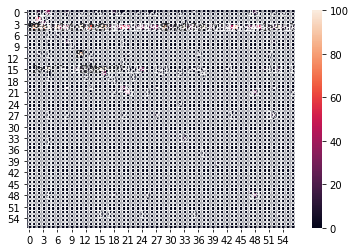

In [417]:
evaluate_model(model, X_test, y_test)